# Import Libraries

In [1]:
import platform
import sys
import os
import json
import pathlib
import requests

import pandas as pd
import numpy as np
import scipy
from scipy.stats import linregress
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

import folium
import pymannkendall as mk
import geopandas as gpd
from rasterstats import zonal_stats
import rioxarray
import xarray
from geocube.api.core import make_geocube

In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
#print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])

Operating System Windows 10
Python Version 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]
Pandas Version 2.2.2
Numpy Version 1.26.4
Matplotlib Version 3.8.4
Scipy Version 1.13.0
pygis311v4


In [3]:
main_path = pathlib.Path("C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant")
figure_dir = main_path / "Writing" / "Figures" / "GEE_out"
raw_dir = main_path / "Pahvant_Basins"
save_place = main_path / "GEE_out"
gis_path = main_path / "GIS_Pahvant"
long_term_rast = main_path / "GEE_Rasters_Pahvant"
short_term_rast = main_path / "OpenET"
short_term_wy = short_term_rast / "valley_area_water_year"
short_term_cy = short_term_rast / "valley_area_calendar_year"
short_term_ir = short_term_rast / "valley_area_irrigation_season"
short_term_cy_ppt = short_term_rast / "valley_area_cal_yr_precip"
short_term_ir_ppt = short_term_rast / "valley_area_irrigation_season_precip"
#G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Pahvant_Basins\GEE_out
#save_place = "GEE_Summary_Out"


In [4]:
#func_path = pathlib.Path(r"G:/Shared drives/UGS_Groundwater/Staff/Inkenbrandt/Pycharm/deformation_gwl")
#sys.path.append(str(func_path))
#import water_budget

## Functions

In [6]:
def scatterColor(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """
    import matplotlib as mpl
    import matplotlib.cm as cm
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const,r2

def getlutrend(wrluy, crop, irr=None, adj=True):
    """
    wrluy = yearly et by landuse with year as index
    crop = type of landuse; ex 'Corn'
    irr = irr method; ex 'Sprinkler'
    """
    if irr:
        crp = wrluy[wrluy['IRR_Method']==irr].dropna(subset=['et_acft_adj'])
    else:
        crp = wrluy.dropna(subset=['et_acft_adj'])
    if adj:
        crpyr = crp.groupby(['Description',crp.index]).sum().loc[crop,'et_acft_adj'].sort_index()
        #alfyr.plot()
    else:
        crpyr = crp.groupby(['Description',crp.index]).sum().loc[crop,'et_acft'].sort_index()
        #alfyr.plot(color='red')
    return crpyr

def plotlu(crpyr, crop, ylab='ET (acft)', axis=None):
    if axis:
        pass
    else:
        fig, axis = plt.subplots(1,1,figsize=(12,9))
    axis.plot(crpyr.index, crpyr, label=crop)
    plotmk(crpyr, axis)
    axis.set_ylabel(ylab)
    axis.set_title(crop)
    axis.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
def plotmk(crpyr,axis, units='ac-ft/yr', color=None):
    """This function plots the Mann Kendall trend
    crpyr = crop year
    axis = matplotlib plotting axis
    """
    seas = mk.yue_wang_modification_test(crpyr)
    mklist = [seas.trend, seas.h, seas.p, seas.z, seas.Tau, seas.s, seas.slope, seas.intercept]
    if mklist[1]:
        frst = crpyr.first_valid_index()
        lst = crpyr.last_valid_index()
        x = range(frst,lst)
        lab = f"MK {mklist[-2]:.2f} {units}"
        if color:
            clr = color
        else:            
            if mklist[0] == 'increasing':
                clr = 'red'
            else:
                clr = 'green'
        axis.plot(x,[(i-1985)*mklist[-2]+mklist[-1] for i in x],label=lab,color=clr)

Define a function that simplifies the OpenET api call.

In [7]:
def call_api(endpoint, api_key, args=None, get=True):
    """Using user specified inputs, returns data from OpenET Raster API.

    Args:
        endpoint (str): Raster API endpoint

        api_key (str): Required api access key

        args (dictionary): User specified arguments for api call
        
        get (bool): use True if a get request and False if a post request

    Returns:
        result (object): An object of Raster API results
    """

    if args:
        args = args
    else:
        args = {}
    
    # api server address
    server = 'https://openet-api.org'

    # initialize request url
    url = server + endpoint

    # create header
    header = {"Authorization": api_key}

    if get:
        # make api get request
        resp = requests.get(url=url, headers=header, params=args, verify=False)

    else: 
        # make api post request
        resp = requests.post(url=url, headers=header, data=json.dumps(args), verify=False)

    # view results
    return resp

# Bring in Water Related Land Use File

EPSG:5070


<Axes: >

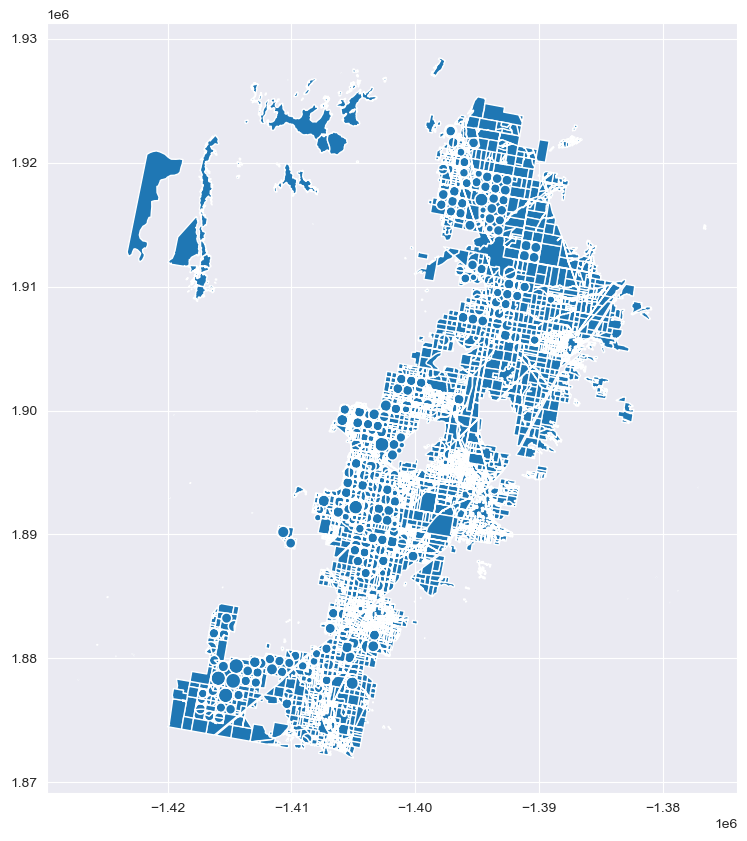

In [8]:
wrlu = gpd.read_file(main_path / "WRLU_POU_GWD.shp")
#wrlu['TARGET_FID'] = wrlu.index
drop_cols = ['Join_Count','Name','RECORD_ID_','RECORD_ID_', 'GROUP_NU_1', 'WRNUMS_1', 'dbURL_1', 'recordID_1']
wrlu = wrlu.drop(drop_cols, axis=1)
wrlu = wrlu.to_crs("EPSG:5070") #https://spatialreference.org/ref/sr-org/7301/ 
wrlu['Acres'] = wrlu.geometry.area*0.000247105

# Project to USA Contiguous Albers Equal Area Conic USGS version (LANDFIRE)

print(wrlu.crs)
#print(wrlu[wrlu['acres']>1000])
#wrlu = wrlu[wrlu['acres']<1000]
wrlu.plot()



Suppress the Insecure Request Warning

From: [https://opendata.gis.utah.gov/datasets/utah::utah-water-related-land-use/about](https://opendata.gis.utah.gov/datasets/utah::utah-water-related-land-use/about)

2021

https://gis.stackexchange.com/questions/427434/query-feature-service-on-esri-arcgis-rest-api-with-python-requests

## Preview Raster Data

* https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/reproject-raster/
* https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/
* https://xarray-spatial.org/user_guide/zonal.html

Look at the raster and overlay the Water Related Land Use (wrlu) data.  The wrlu data are from the [Utah Division of Water Resources](https://gis.utah.gov/data/planning/water-related-land/).

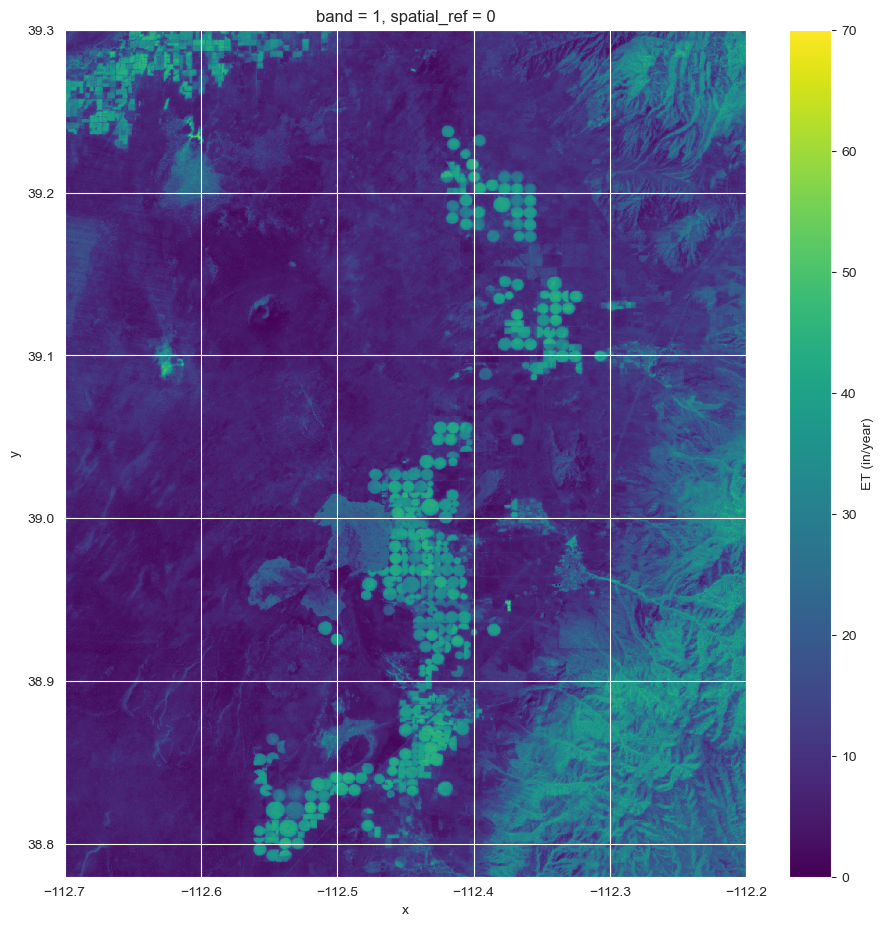

In [18]:
f, ax = plt.subplots(figsize=(11, 11))
et_cy_2021 = rioxarray.open_rasterio(short_term_cy / "6156_ensemble_et_public_ent_vly_area_2021_yr_0.tif", 
                                     masked=True, mask_and_scale=True).squeeze()
et_cy_2021.plot.imshow(vmin=0,vmax=70,ax=ax,cbar_kwargs={"label": "ET (in/year)"})

In [19]:
wrlu

,TARGET_FID,Landuse,CropGroup,Descriptio,IRR_Method,Acres,Label_Clas,LABEL,Class_Name,OldLanduse,...,Landuse_1,IRR_Meth_1,WaterSourc,Irrigation,FarmName,ProofName,Name_1,SHAPE_Leng,SHAPE_Area,geometry
0,1,Agricultural,Hay/Turf,Alfalfa,Flood,5.040700,ALF-F Alfalfa,ALF-F,Alfalfa,IR,...,Agricultural,Flood,Surface,None,None,None,Flowell,0.006829,0.000002,"POLYGON Z ((-1400565.724 1894898.558 0.000, -1..."
1,2,Agricultural,Hay/Turf,Alfalfa,Flood,2.905354,ALF-F Alfalfa,ALF-F,Alfalfa,IR,...,Agricultural,Flood,Surface,None,None,None,Flowell,0.004888,0.000001,"POLYGON Z ((-1395304.369 1895031.419 0.000, -1..."
2,3,Agricultural,Hay/Turf,Alfalfa,Flood,4.979551,ALF-F Alfalfa,ALF-F,Alfalfa,IR,...,Agricultural,Flood,Surface,None,None,None,Greenwood,0.006388,0.000002,"POLYGON Z ((-1387877.307 1905573.486 0.000, -1..."
3,4,Agricultural,Hay/Turf,Alfalfa,Flood,5.464141,ALF-F Alfalfa,ALF-F,Alfalfa,IR,...,Agricultural,Flood,Surface,Recent,None,None,Greenwood,0.006848,0.000002,"POLYGON Z ((-1388344.772 1905225.634 0.000, -1..."
4,5,Agricultural,Hay/Turf,Alfalfa,Flood,79.163816,ALF-F Alfalfa,ALF-F,Alfalfa,IR,...,Agricultural,None,Surface,Very Recent,None,None,Greenwood,0.020770,0.000033,"POLYGON Z ((-1389105.086 1908630.184 0.000, -1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6164,4038,Agricultural,Pasture Land,Pasture,Dry Crop,308.760715,DRYPAS Grassland/Pasture,DRYPAS,Grassland/Pasture,NI,...,Agricultural,Dry Crop,Ground,Recent,None,None,Kanosh,0.085360,0.000322,"POLYGON Z ((-1416897.185 1873925.039 0.000, -1..."
6165,4098,Agricultural,Pasture Land,Pasture,Dry Crop,4.495166,DRYPAS Grassland/Pasture,DRYPAS,Grassland/Pasture,NI,...,None,None,None,None,None,None,Meadow,0.012078,0.000009,"POLYGON Z ((-1411418.114 1872959.965 0.000, -1..."
6166,4276,Agricultural,Pasture Land,Pasture,Dry Crop,12.613088,DRYPAS Other,DRYPAS,Shrubland,NI,...,None,None,None,None,None,None,Kanosh,0.020360,0.000016,"POLYGON Z ((-1412556.379 1873160.140 0.000, -1..."
6167,4284,Agricultural,Pasture Land,Pasture,Dry Crop,196.574065,DRYPAS Other,DRYPAS,Shrubland,NI,...,Agricultural,Dry Crop,None,None,None,None,Kanosh,0.057800,0.000174,"POLYGON Z ((-1414901.664 1873573.106 0.000, -1..."


## Run Zonal Statistics

In [20]:
def calc_zonal_stats(varib, rast_dir, wrlu):
    """Combines rasters in a folder into one xarray object.  Uses zonal statistics to summarize a polygon dataset.
    * From: https://corteva.github.io/geocube/html/examples/zonal_statistics.html
    
    varib = the variable name you want to assign to the zonal statistics columns; columns are mean and std
    rast_dir = folder with rasters of interest.  Must extend from 2016 to 2022.  If different, modify function
    wrlu = polygon of fields; must include luid field
    
    """
    timelst = []
    xry = []
    
    # Open, reproject, clip, and combine rasters.
    for file in rast_dir.glob("*.tif"):
        fname = file.name.split('.')[0][1:]
        # open raster
        rast = rioxarray.open_rasterio(file, masked=True, mask_and_scale=True).squeeze()
        # reproject raster to albers
        clipped = rast.rio.reproject(wrlu.crs)
        # pull year from file name and append to list
        timelst.append(int(fname.split("_")[-3]))
        xry.append(clipped)

    # combine rasters into xarray dataset
    da = xarray.concat(xry, dim=timelst).sortby("concat_dim").rename({"concat_dim":"year"})

    # Create the data mask by rasterizing the unique ID of the vector data
    # ensure the vector data are on the same grid as the stacked raster data
    out_grid = make_geocube(vector_data=wrlu, measurements=["TARGET_FID"], like=da) 

    # Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
    out_grid["vals"] = (da.dims, da.values, da.attrs, da.encoding)
    #grouped_data = out_grid.drop("spatial_ref").groupby(out_grid['TARGET_FID'])
    grouped_data = out_grid.drop_vars("spatial_ref").groupby(out_grid['TARGET_FID'])
    grid_mean = grouped_data.mean().rename({"vals": f"{varib}_mean"})
    #grid_std = grouped_data.std().rename({"vals": f"{varib}_std"})

    zone_stat = xarray.merge([grid_mean]).to_dataframe()

    zn = zone_stat.rename(index={0:2016,1:2017,2:2018,3:2019,4:2020,5:2021,6:2022},level=1)
    #zn = zn.drop(['spatial_ref'],axis=1)
    
    return zn




In [21]:
ppt_zn = calc_zonal_stats("PPT", short_term_cy_ppt, wrlu)
et_zn = calc_zonal_stats("ETcy", short_term_cy, wrlu)
irret_zn = calc_zonal_stats("ETir", short_term_ir, wrlu)
irrppt_zn = calc_zonal_stats("PPTir",short_term_ir_ppt, wrlu)

zonal_combo = pd.concat([ppt_zn,et_zn,irret_zn,irrppt_zn],axis=1)

C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_23504\4260475114.py:33: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  grouped_data = out_grid.drop("spatial_ref").groupby(out_grid['TARGET_FID'])
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_23504\4260475114.py:33: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  grouped_data = out_grid.drop("spatial_ref").groupby(out_grid['TARGET_FID'])
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_23504\4260475114.py:33: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  grouped_data = out_grid.drop("spatial_ref").groupby(out_grid['TARGET_FID'])
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_23504\4260475114.py:33: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  grouped_data = out_grid.drop("spatial_ref").groupby(out_grid['TARGET_FID'])


In [118]:


wrlu_zonal = wrlu.merge(zonal_combo.reset_index(), on="TARGET_FID")

calc_varibs = ["PPT","ETcy","ETir","PPTir"]
for varib in calc_varibs:

    wrlu_zonal[f'{varib}_acft'] = wrlu_zonal['Acres'] * 0.0833333 * wrlu_zonal[f'{varib}_mean']

    
wrlu_zonal[f'NonIRR_ET'] = wrlu_zonal[f'ETcy_acft'] - wrlu_zonal[f'ETir_acft']
wrlu_zonal[f'ET-PPT'] = wrlu_zonal[f'ETcy_acft'] - wrlu_zonal[f'PPT_acft']
wrlu_zonal[f'ETir-PPTir'] = wrlu_zonal[f'ETir_acft'] - wrlu_zonal[f'PPTir_acft']

wrlu_zonal['PPT_acft']

0        5.629433
1        5.531862
2        5.898996
3        6.763917
4        2.844484
           ...   
42877    0.665279
42878    0.841693
42879    0.369432
42880    0.659053
42881    0.502827
Name: PPT_acft, Length: 42882, dtype: float64

In [131]:
fields = ['PPT_acft','PPTir_acft','ETcy_acft','ETir_acft','ET-PPT', 'ETir-PPTir']

wrluz = range(2016,2023)

lu, ws, im, nm, fm, ol, cr = {},{},{},{},{},{},{}

for yr in wrluz:
    wrl = wrlu_zonal[wrlu_zonal['year']==yr]        
    lu[yr] = wrl.groupby('Landuse').sum(numeric_only=True)[fields].round(-2).astype(int)
    ws[yr] = wrl.groupby('WaterSourc').sum(numeric_only=True)[fields].round(-2).astype(int)
    im[yr] = wrl.groupby('IRR_Meth_1').sum(numeric_only=True)[fields].round(-2).astype(int)
    nm[yr] = wrl.groupby('Name_1').sum(numeric_only=True)[fields].round(-2).astype(int)
    fm[yr] = wrl.groupby('FarmName').sum(numeric_only=True)[fields].round(-2).astype(int)
    ol[yr] = wrl.groupby('OldLanduse').sum(numeric_only=True)[fields].round(-2).astype(int)
    cr[yr] = wrl.groupby('Creek').sum(numeric_only=True)[fields].round(-2).astype(int)


lual = pd.concat(lu,axis=1).stack()
lual['avg'] = lual.mean(axis=1)
wsal = pd.concat(ws,axis=1).stack()
wsal['avg'] = wsal.mean(axis=1)
imal = pd.concat(im,axis=1).stack()
imal['avg'] = imal.mean(axis=1)
nmal = pd.concat(nm,axis=1).stack()
nmal['avg'] = nmal.mean(axis=1)
fmal = pd.concat(fm,axis=1).stack()
fmal['avg'] = fmal.mean(axis=1)
olal = pd.concat(ol,axis=1).stack()
olal['avg'] = olal.mean(axis=1)
cral = pd.concat(cr,axis=1).stack()
cral['avg'] = cral.mean(axis=1)

dfs = {'Landuse':lual,'Water Source':wsal, 'IRR Meth':imal,'Name':nmal,'Farm Name':fmal,'Old Landuse':olal,'Creek':cral}

with pd.ExcelWriter(main_path / 'wrlu_et.xlsx') as writer:
    for key,val in dfs.items():
        val.to_excel(writer, sheet_name=f'{key}')

In [144]:
wrlu = gpd.read_file(main_path / "Wetlands_for_ET.shp")

wrlu = wrlu.to_crs("EPSG:5070") #https://spatialreference.org/ref/sr-org/7301/ 
wrlu['Acres'] = wrlu.geometry.area*0.000247105
wrlu['TARGET_FID'] = wrlu.index
# Project to USA Contiguous Albers Equal Area Conic USGS version (LANDFIRE)

print(wrlu.crs)

ppt_zn = calc_zonal_stats("PPT", short_term_cy_ppt, wrlu)
et_zn = calc_zonal_stats("ETcy", short_term_cy, wrlu)
irret_zn = calc_zonal_stats("ETir", short_term_ir, wrlu)
irrppt_zn = calc_zonal_stats("PPTir",short_term_ir_ppt, wrlu)

zonal_combo = pd.concat([ppt_zn,et_zn,irret_zn,irrppt_zn],axis=1)

wrlu_zonal = wrlu.merge(zonal_combo.reset_index(), on="TARGET_FID")

calc_varibs = ["PPT","ETcy","ETir","PPTir"]
for varib in calc_varibs:

    wrlu_zonal[f'{varib}_acft'] = wrlu_zonal['Acres'] * 0.0833333 * wrlu_zonal[f'{varib}_mean']

    
wrlu_zonal[f'NonIRR_ET'] = wrlu_zonal[f'ETcy_acft'] - wrlu_zonal[f'ETir_acft']
wrlu_zonal[f'ET-PPT'] = wrlu_zonal[f'ETcy_acft'] - wrlu_zonal[f'PPT_acft']
wrlu_zonal[f'ETir-PPTir'] = wrlu_zonal[f'ETir_acft'] - wrlu_zonal[f'PPTir_acft']



fields = ['PPT_acft','PPTir_acft','ETcy_acft','ETir_acft','ET-PPT', 'ETir-PPTir']



wrluz = range(2016,2023)

lu, ws, im, cn, ir, ol = {},{},{},{},{},{}

for yr in wrluz:
    wrl = wrlu_zonal[wrlu_zonal['year']==yr]        
    lu[yr] = wrl.groupby('Landuse').sum(numeric_only=True)[fields].round(-2).astype(int)
    ws[yr] = wrl.groupby('WaterSourc').sum(numeric_only=True)[fields].round(-2).astype(int)
    im[yr] = wrl.groupby('IRR_Method').sum(numeric_only=True)[fields].round(-2).astype(int)
    cn[yr] = wrl.groupby('Class_Name').sum(numeric_only=True)[fields].round(-2).astype(int)
    ir[yr] = wrl.groupby('Irrigation').sum(numeric_only=True)[fields].round(-2).astype(int)
    ol[yr] = wrl.groupby('Descriptio').sum(numeric_only=True)[fields].round(-2).astype(int)



lual = pd.concat(lu,axis=1).stack()
lual['avg'] = lual.mean(axis=1)
wsal = pd.concat(ws,axis=1).stack()
wsal['avg'] = wsal.mean(axis=1)
imal = pd.concat(im,axis=1).stack()
imal['avg'] = imal.mean(axis=1)
cnal = pd.concat(nm,axis=1).stack()
cnal['avg'] = nmal.mean(axis=1)
iral = pd.concat(fm,axis=1).stack()
iral['avg'] = fmal.mean(axis=1)
olal = pd.concat(ol,axis=1).stack()
olal['avg'] = olal.mean(axis=1)


dfs = {'Landuse':lual,'Water Source':wsal,
       'IRR Meth':imal,'Class Name':cnal,'Irrigation':iral,
       'Description':olal}

with pd.ExcelWriter(main_path / 'wetland_et.xlsx') as writer:
    for key,val in dfs.items():
        val.to_excel(writer, sheet_name=f'{key}')


EPSG:5070


# Long-Term ET

## By Hydro Division

Stack Rasters outputs from SSEBop analysis

In [8]:
gee_gis_dir = gis_path / "GEE_Rasters_Pahvant"

hydrodivs = gpd.read_file(gis_path / 'Valley_Hydrogeologic_Divisions.shp')
eastarea = hydrodivs[~hydrodivs['WRarea'].isin(['Oasis','West Desert','Clear Lake'])].dissolve()
east_divs = hydrodivs[~hydrodivs['WRarea'].isin(['Oasis','West Desert','Clear Lake'])]

In [11]:
east_divs

,Bdrk_v_Val,WRarea,Watershed,Notes,ID,Shape_Leng,Shape_Area,geometry
1,Valley,Kanosh,Dry Wash,NaN,3,78841.735256,1.703117e+08,"POLYGON Z ((-1413752.283 1883985.547 0.000, -1..."
4,Valley,McCornick,Whiskey Creek,NaN,7,93790.542635,2.572118e+08,"POLYGON Z ((-1404722.275 1911181.008 0.000, -1..."
6,Bdrk,Greenwood,Ebbs Canyon,NaN,11,75929.789393,1.081123e+08,"POLYGON Z ((-1376396.192 1921541.883 0.000, -1..."
9,Valley,Greenwood,Oak Spring,NaN,14,83371.141920,2.372979e+08,"POLYGON Z ((-1386369.216 1912949.418 0.000, -1..."
11,Bdrk,Greenwood,Maple Hollow,NaN,21,41901.911484,6.714904e+07,"POLYGON Z ((-1386156.710 1901796.827 0.000, -1..."
12,Bdrk,Pavant,Pioneer Creek,NaN,22,41707.810679,5.485854e+07,"POLYGON Z ((-1390103.123 1896139.745 0.000, -1..."
13,Basalt,Flowell,Deveils Kitchen,NaN,23,75037.997534,2.110666e+08,"POLYGON Z ((-1411121.634 1890574.629 0.000, -1..."
14,Valley,Flowell,Pine Creek,NaN,26,67752.848609,1.869851e+08,"POLYGON Z ((-1405776.744 1894784.418 0.000, -1..."
15,Bdrk,Flowell,Chalk Creek,NaN,27,58849.105042,1.535622e+08,"POLYGON Z ((-1392435.808 1889603.490 0.000, -1..."
16,Valley,Meadow,Mud Lake,NaN,33,65172.907230,1.835285e+08,"POLYGON Z ((-1413402.257 1883904.417 0.000, -1..."


<AxesSubplot: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

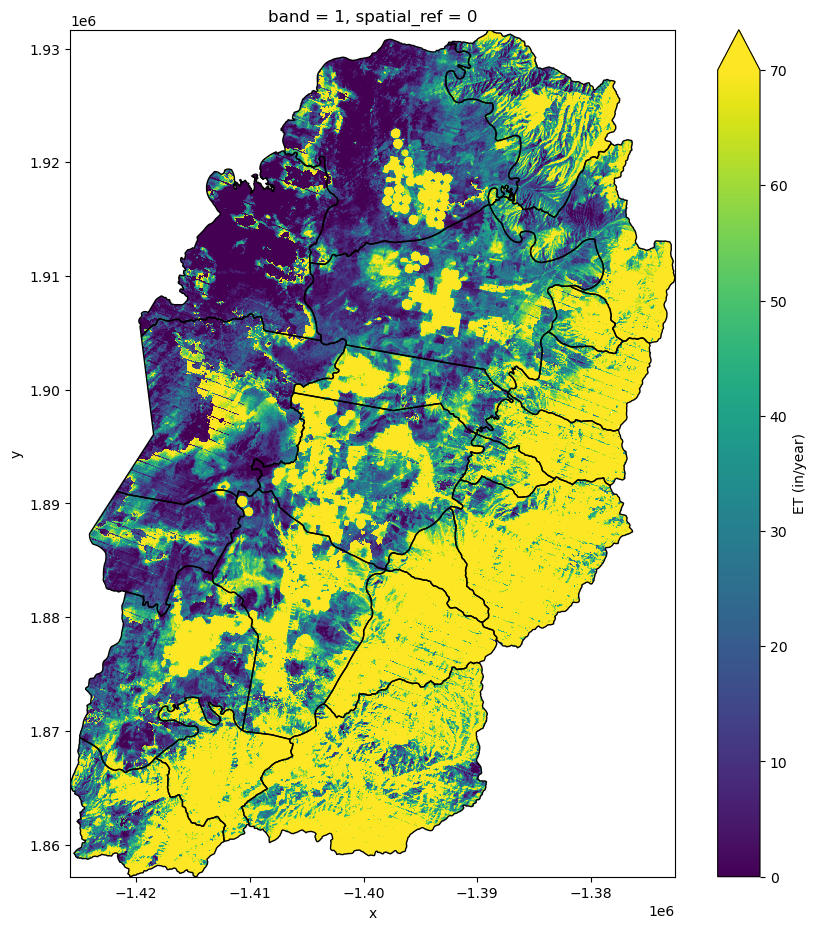

In [95]:
f, ax = plt.subplots(figsize=(11, 11))




ssebob_20070501 = rioxarray.open_rasterio("G:/Shared Drives/UGS_Groundwater/Projects/Pahvant_Valley/GIS_Pahvant/GEE_SSEBop_ET_Rasters_Clipped/t2013-05-01.tif", 
                                     masked=True, mask_and_scale=True).squeeze()

#ssebob_20070501alb = ssebob_20070501.rio.reproject(eastarea.crs)

ssebob_20070501.plot.imshow(vmin=0,vmax=70,ax=ax,cbar_kwargs={"label": "ET (in/year)"})
east_divs.geometry.plot(color="None",edgecolor='k',ax=ax)

In [167]:
timelst = []

#outpath = gis_path /  "GEE_SSEBop_ET_Rasters_Clipped"
gee_gis_dir = gis_path /  "GEE_SSEBop_ET_Rasters_Clipped"
    
#collecting datasets when looping over your files
list_da = []

zonal = {}

for file in gee_gis_dir.glob("*.tif"):
    fname = file.name.split('.')[0][1:]
    dt = pd.to_datetime(fname)

    da = rioxarray.open_rasterio(file, masked=True, mask_and_scale=True).squeeze()

    da = da.where(da!=da.rio.nodata)
    da = da.assign_coords(time = dt)
    da = da.expand_dims(dim="time")
        
    out_grid = make_geocube(vector_data=east_divs, measurements=["ID"], like=da) 

    # Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
    out_grid["vals"] = (da.dims, da.values, da.attrs, da.encoding)

    grouped_data = out_grid.drop("spatial_ref").groupby(out_grid['ID'])
    grid_mean = grouped_data.mean().rename({"vals": "ET_mean"})

    zone_stat = grid_mean.to_dataframe()
    zone_stat['time'] = dt
    zonal[dt] = zone_stat
        
ssebop_data = pd.concat(zonal)

In [157]:
ssebp = ssebop_data.drop(['spatial_ref','time'],axis=1).reset_index().rename(columns={'level_0':'date',
                                                                                      'ET_mean':'ssebop_aet_in'})
ssebp = ssebp.drop(['time'],axis=1).sort_values('date')
ssebp
#.to_csv(save_place / "ssebop_monthly.csv")

,date,ID,ssebop_aet_in
0,2012-07-01,3.0,33.536592
1,2012-07-01,7.0,31.116286
2,2012-07-01,11.0,63.680375
3,2012-07-01,14.0,29.393958
4,2012-07-01,21.0,87.693553
...,...,...,...
5539,2003-03-01,60.0,85.712615
5540,2003-03-01,67.0,65.094158
5541,2003-03-01,77.0,78.432153
5542,2003-03-01,118.0,15.230891


<AxesSubplot: xlabel='date'>

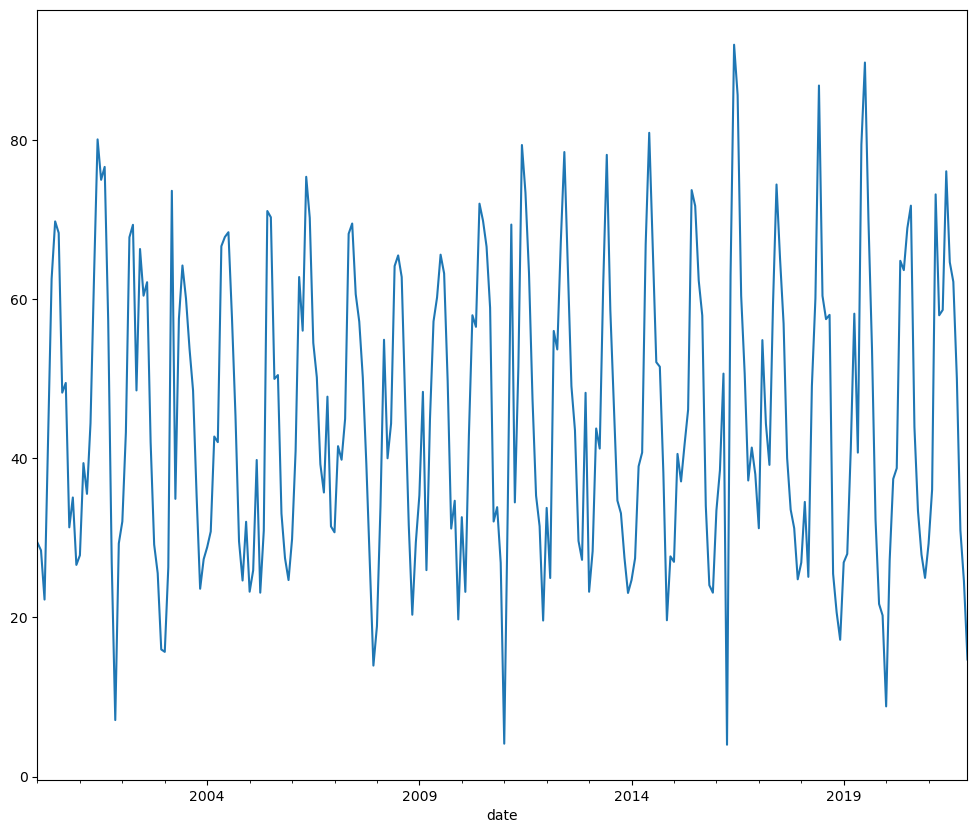

In [159]:
ssebp.groupby('date').median()['ssebop_aet_in'].plot()

Merge polygon data with raster zonal summary

<AxesSubplot: >

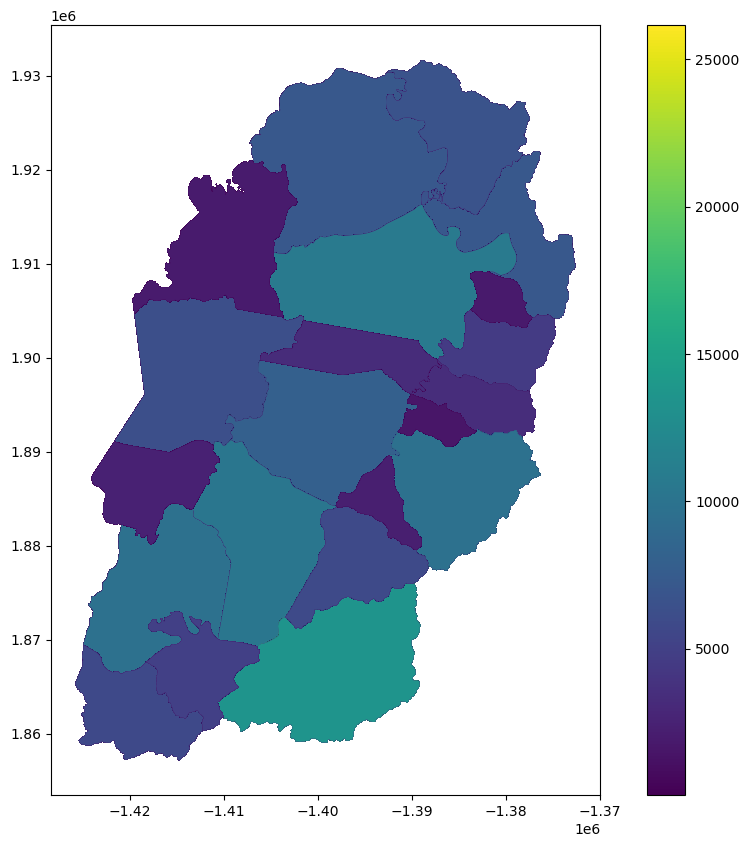

In [160]:
hydro_div_et = hydrodivs.merge(ssebp.reset_index(), on="ID")
hydro_div_et['ssebop_aet'] = hydro_div_et.geometry.area * 0.000247105 * hydro_div_et['ssebop_aet_in'] * 0.00328084 # area * m to ac * mm ET * mm to ft
hydro_div_et
hydro_div_et.plot(column='ssebop_aet', legend=True)

In [162]:
hydro_div_et[['date','ssebop_aet','ID']].rename(columns={'ID':'hucname'}).to_csv(save_place / 'ssebop_mo.csv')

In [166]:
hydro_div_et['date'].sort_.unique()

## By WRLU

In [ ]:
timelst = []
xry = []

gee_gis_dir = gis_path / "GEE_Rasters_Pahvant"
    
import xarray as xr
from datetime import datetime
import pandas as pd

#collecting datasets when looping over your files
list_da = []

for file in gee_gis_dir.glob("*.tif"):
    fname = file.name.split('.')[0][1:]
    #path = "tifs/DTSLOS_20170122_20190828_D79H_2017-02-15T06:13:38Z.tif"
    #da = xr.open_rasterio(path)
    #da = rioxarray.open_rasterio(file, masked=True, mask_and_scale=True).squeeze()

    #time = path.split("_")[-1].split("Z")[0]
    #dt = datetime.strptime(time,"%Y-%m-%dT%H:%M:%S")
    dt = pd.to_datetime(fname)
    print(dt)
    #da = da.assign_coords(time = dt)
    #da = da.expand_dims(dim="time")
    timelst.append(dt)
    #list_da.append(da)

#stack dataarrays in list
ds = xr.combine_by_coords(list_da)

In [ ]:
wrlu_new = wrlu[wrlu['SURV_YEAR']==2021]
# Create the data mask by rasterizing the unique ID of the vector data
# ensure the vector data are on the same grid as the stacked raster data
out_grid = make_geocube(vector_data=wrlu_new, measurements=["luid"], like=ds) 

# Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
out_grid["vals"] = (ds.dims, ds.values, ds.attrs, ds.encoding)
grouped_data = out_grid.drop("spatial_ref").groupby(out_grid.luid)
grid_mean = grouped_data.mean().rename({"vals": "ET_mean"})
grid_std = grouped_data.std().rename({"vals": "ET_std"})

zone_stat = xarray.merge([grid_mean, grid_std]).to_dataframe()
zone_stat
#zn = zone_stat.rename(index={0:2016,1:2017,2:2018,3:2019,4:2020,5:2021,6:2022},level=1)
zn = zn.drop(['spatial_ref'],axis=1)

In [ ]:
# initializing lists
test_keys = zone_stat.index.get_level_values(1).unique()
test_values = ds['time'].values
 
# using dictionary comprehension
# to convert lists to dictionary
res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

zn = zone_stat.rename(index=res,level=1)
zn = zn.drop(['spatial_ref'],axis=1)

In [ ]:
"Descriptio"

In [ ]:
wrlu_z = wrlu_new.merge(zn.reset_index(), on="luid")

In [ ]:
irr_longterm = wrlu_z.groupby(['IRR_Method','time']).mean()
irr_longterm['ET_mean'].unstack(level=0).groupby(pd.Grouper(freq='1YS')).sum().plot()
plt.grid()

In [ ]:
irr_longterm['ET_mean'].unstack(level=0)

In [ ]:
irr_longterm = wrlu_z.groupby(["Descriptio",'time']).mean()
irr_longterm['ET_mean'].unstack(level=0)[['Wetland','Water','Shallow Groundwater','Dry Channel/Pool']].groupby(pd.Grouper(freq='1YS')).sum().plot()
plt.grid()



In [ ]:
irr_longterm = wrlu_z.groupby(['IRR_Method','time']).mean()
irr_longterm['ET_mean'].unstack(level=0).groupby(pd.Grouper(freq='1YS')).sum().plot()
plt.grid()

In [ ]:
irr_longterm.loc['Sprinkler']['ET_mean'].plot()
plt.grid()
plt.ylabel('ET (mm/yr)')

In [ ]:
wrlu_z = wrlu_new.merge(zonal_combo.reset_index(), on="luid")

calc_varibs = ["PPT","ETcy","ETir","PPTir"]
for varib in calc_varibs:

    wrlu_z[f'{varib}_acft'] = wrlu_z['Acres'] * 0.0833333 * wrlu_z[f'{varib}_mean']
    wrlu_z[f'{varib}_std_acft'] = wrlu_z['Acres'] * 0.0833333 * wrlu_z[f'{varib}_std']

wrlu2022[f'Pcnt_IRR_ET'] = wrlu2022['ETir_acft']/wrlu2022['ETcy_acft']
wrlu2022[f'Pcnt_PPT_ET'] = wrlu2022[f'PPT_acft']/wrlu2022['ETcy_acft']
wrlu2022[f'NonIRR_ET'] = wrlu2022[f'ETcy_acft'] - wrlu2022[f'ETir_acft']
wrlu2022[f'ET-PPT'] = wrlu2022[f'ETcy_acft'] - wrlu2022[f'PPT_acft']
wrlu2022[f'ETir-PPTir'] = wrlu2022[f'ETir_acft'] - wrlu2022[f'PPTir_acft']

In [ ]:
ds['time'].values

In [ ]:
short_et_wrlu_ir = {}

for file in short_term_cy.glob("*.tif"):
    fname = file.name.split('.')[0][1:]
    try:
        tests = zonal_stats_ir(wrlu, file, nodata=-999, stats=["count", "std","sum", "mean", "median"], geojson_out=True)
        short_et_wrlu[fname] = gpd.GeoDataFrame.from_features(tests)
        print(fname)
    except rasterio.errors.RasterioIOError:
        print(f"{fname} bad")
        pass

In [ ]:
wrlu_data = gpd.read_file(gis_path / "wrlu_et.gpkg", layer='wrlu_et', driver="GPKG")

In [ ]:
wrlu_data

In [ ]:

et_wrlu = {}

for file in long_term_rast.glob("*.tif"):
    fname = file.name.split('.')[0][1:]
    if fname in wrlu_data['level_0'].unique():
        pass
    else:
        try:
            tests = zonal_stats(wrlu, file, nodata=-999, stats=["count", "std","sum", "mean", "median"], geojson_out=True)
            et_wrlu[fname] = gpd.GeoDataFrame.from_features(tests)
            print(fname)
        except rasterio.errors.RasterioIOError:
            print(f"{fname} bad")
            pass
    

In [ ]:
pd.concat(et_wrlu)#.to_file(gis_path / "wrlu_et.gpkg", layer='wrlu_et', driver="GPKG")

In [ ]:


tests =zonal_stats(wrlu, et_fp,nodata=-999,
            stats=["count", "std","sum", "mean", "median"],geojson_out=True)
gpd.GeoDataFrame.from_features(tests)

In [ ]:

gpd.GeoDataFrame.from_features(tests)